In [1]:
'''load packages'''
import pandas as pd
import numpy as np
import os
from gensim.models import word2vec
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score

In [29]:
batch_size = 128
num_classes = 127  # 输出类别
context_size = 36  # 句子长度（字词个数）
num_embeddings = 7102  # 词典的大小(vocab_size)
embedding_dim = 8  # 词向量特征长度
kernel_sizes = [2, 4]  # CNN层卷积核大小
num_channels = [4, 5]  # CNN层卷积核通道数
LARGE_SENTENCE_SIZE = 36  # 句子最大长度
BATCH_SIZE = 256          # 语料批次大小
LEARNING_RATE = 0.001   # 学习率大小
EMBEDDING_SIZE = 50      # 词向量维度
KERNEL_LIST = [3, 4, 5]   # 卷积核长度
FILTER_NUM = 100          # 每种卷积核输出通道数
DROPOUT = 0.5             # dropout概率
EPOCH = 200                # 训练轮次

In [3]:
data=pd.read_csv("D:\\jupyter notebook\\trb.csv")

In [4]:
# data=pd.read_csv('cleaned_data.csv')

In [5]:
data = data[data['antigen.epitope'].map(data['antigen.epitope'].value_counts()) > 20] #drop the clusters with little data

In [6]:
data

,complex.id,gene,cdr3,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.gene,...,j.segm_1,j.segm_2,j.segm_3,mhc.a_0,mhc.a_1,mhc.a_2,mhc.a_3,mhc.a_4,mhc.a_5,mhc.a_6
0,0,1,CATSDASLSSYNEQFF,TRBJ2-1*01,HomoSapiens,HLA-A*01,B2M,0,ATDALMTGY,NS3,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,0,1,CASSLRTAGYNEQFF,TRBJ2-1*01,HomoSapiens,HLA-A*01,B2M,0,ATDALMTGY,NS3,...,0.0,0.0,0.0,0,0,0,0,0,0,1
2,0,1,CASSLWGADGYTF,TRBJ1-2*01,HomoSapiens,HLA-A*01,B2M,0,ATDALMTGY,NS3,...,0.0,1.0,0.0,0,0,0,0,0,0,1
4,0,1,CASRSLLGTRVETEAFF,TRBJ1-1*01,HomoSapiens,HLA-A*01,B2M,0,ATDALMTGY,NS3,...,0.0,0.0,1.0,0,0,0,0,0,0,1
5,0,1,CAISESPQSYEQYF,TRBJ2-7*01,HomoSapiens,HLA-A*01,B2M,0,ATDALMTGY,NS3,...,1.0,1.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49611,0,1,CASSQLSSVNNEQFF,TRBJ2-1*01,HomoSapiens,HLA-DRA1*01,HLA-DRB1*15,1,LLQTGIHVRVSQPSL,pp65,...,0.0,0.0,0.0,1,1,0,1,0,0,0
49612,0,1,CASSDRAQPQHF,TRBJ1-5*01,HomoSapiens,HLA-DRA1*01,HLA-DRB1*15,1,LLQTGIHVRVSQPSL,pp65,...,1.0,0.0,1.0,1,1,0,1,0,0,0
49613,0,1,CASRPGQNYEQYF,TRBJ2-7*01,HomoSapiens,HLA-DRA1*01,HLA-DRB1*15,1,LLQTGIHVRVSQPSL,pp65,...,1.0,1.0,0.0,1,1,0,1,0,0,0
49614,0,1,CASSLMSSYNSPLHF,TRBJ1-6*01,HomoSapiens,HLA-DRA1*01,HLA-DRB1*11:01,1,EHPTFTSQYRIQGKL,pp65,...,1.0,1.0,0.0,1,1,0,1,0,0,0


In [7]:
data=data.drop_duplicates()

In [8]:
def generate_kmers(sequence, k):
    """Generate k-mers for a given sequence."""
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]
k=3 # change the k for kmers
all_kmers = [kmer for seq in data['cdr3'] for kmer in generate_kmers(seq, k)]

# Count the frequency of each 4-mer
kmer_counts = Counter(all_kmers)

In [9]:
sentence=[]
for seq in data['cdr3']:
    temp=generate_kmers(seq,k)
    sentence.append(temp)
f=open('kmer_3.txt','w')
f.writelines('\n'.join([' '.join(l) for l in sentence]))
'''add to data'''
data=data.reset_index()
data['kmers']=pd.Series(sentence)

In [10]:
len(sentence)

43941

In [11]:
len(np.array(data['kmers'])[0])

14

In [11]:
from gensim.models import Word2Vec
kmer_model=Word2Vec.load('.\model\kmer_word2vec_50.model')

In [12]:
def embedding(data,model):
    vec=[]
    vectors = model.wv
    length=data.map(len).max()
    for sentence in list(data):
        sentence=list(sentence)
        sentence_vector=[vectors[i] for i in sentence]
#         print(len(sentence_vector))
        while len(sentence_vector)<length:
            sentence_vector.append(np.zeros_like(vectors[sentence[0]]))
#         print(sentence_vector)
        vec.append(sentence_vector)
    return vec

In [14]:
trb_embed=embedding(data['kmers'],kmer_model)
data['kmers']=trb_embed

In [15]:
data.columns

Index(['index', 'complex.id', 'gene', 'cdr3', 'j.segm', 'species', 'mhc.a',
       'mhc.b', 'mhc.class', 'antigen.epitope', 'antigen.gene',
       'antigen.species', 'vdjdb.score', 'v.seg', 'd.segm', 'mhc.b_label',
       'kmers', 'antigen_label', 'cdr_label', 'crd3_encode', 'v.seg_0',
       'v.seg_1', 'v.seg_2', 'v.seg_3', 'v.seg_4', 'v.seg_5', 'd.segm_0',
       'j.segm_0', 'j.segm_1', 'j.segm_2', 'j.segm_3', 'mhc.a_0', 'mhc.a_1',
       'mhc.a_2', 'mhc.a_3', 'mhc.a_4', 'mhc.a_5', 'mhc.a_6'],
      dtype='object')

In [16]:
data.drop(['index', 'complex.id', 'gene', 'cdr3', 'j.segm', 'species', 'mhc.a',
       'mhc.b', 'mhc.class', 'antigen.epitope', 'antigen.gene',
       'antigen.species'],axis=1,inplace=True)

In [17]:
data.drop(['v.seg', 'd.segm', 'mhc.b_label','cdr_label','d.segm_0'],axis=1,inplace=True)

In [13]:
target=data['antigen_label']

In [14]:
data=data.fillna(0)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43941 entries, 0 to 43940
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            43941 non-null  int64  
 1   complex.id       43941 non-null  int64  
 2   gene             43941 non-null  int64  
 3   cdr3             43941 non-null  object 
 4   j.segm           43941 non-null  object 
 5   species          43941 non-null  object 
 6   mhc.a            43941 non-null  object 
 7   mhc.b            43941 non-null  object 
 8   mhc.class        43941 non-null  int64  
 9   antigen.epitope  43941 non-null  object 
 10  antigen.gene     43941 non-null  object 
 11  antigen.species  43941 non-null  object 
 12  vdjdb.score      43941 non-null  int64  
 13  v.seg            43941 non-null  object 
 14  d.segm           43941 non-null  float64
 15  mhc.b_label      43941 non-null  int64  
 16  kmers            43941 non-null  object 
 17  antigen_labe

In [16]:
#copy data according to score
data=pd.concat([data,data[data['vdjdb.score']==1]])
data=pd.concat([data,data[data['vdjdb.score']==2]])
data=pd.concat([data,data[data['vdjdb.score']==2]])

----------------------------finish data processing

### only use cdr

In [17]:
# 将词向量作为embedding层的初始值
weights = torch.FloatTensor(kmer_model.wv.vectors)
embedding= nn.Embedding.from_pretrained(embeddings=weights, freeze=False)
# 构建词典
idx2word ={ i:k for i,k in enumerate(kmer_model.wv.key_to_index.keys())}
word2idx ={ k:i for i,k in enumerate(kmer_model.wv.key_to_index.keys())}

In [18]:
# 定义新词
pad_word,unk_word,other_label ='<pad>', '<unk>', 'Other'

new_id=len(word2idx)
idx2word[new_id]=pad_word
word2idx[pad_word]=new_id
print(word2idx[pad_word])

7102


In [19]:
# 构建词向量，并添加到权值矩阵中
embedding_dim=50  #尝试100，不咋地 换50 更不行
new_vec=np.random.uniform(-np.sqrt(3.0 / embedding_dim), np.sqrt(3.0 / embedding_dim), embedding_dim)
new_vec=torch.Tensor(new_vec).view(1,-1)
weights=torch.cat([weights,new_vec],dim=0)
print(weights.size())

torch.Size([7103, 50])


In [20]:
# split dataset
train_data, test_data = train_test_split(data, 
                                          stratify=data['antigen.epitope'], 
                                          train_size=0.8, 
                                          test_size=0.2)

In [21]:

m=context_size
train_texts=[]
train_inputs=[]
for i in train_data['kmers']:
    if len(i)>int(m):
        i=i[0:int(m)]
    else:
        i+=['<pad>']*(int(m)-len(i))
    t=[]
    item=[]
    for j in i:
        #print(j)
        t.append(weights[word2idx[j]].tolist())
        item.append(word2idx[j])
    #print(t)
    train_texts.append(t)
    train_inputs.append(item) # index of words

test_texts=[]
test_inputs=[]
for i in test_data['kmers']:
    if len(i)>int(m):
        i=i[0:int(m)]
    else:
        i+=['<pad>']*(int(m)-len(i))
    t=[]
    item=[]
    for j in i:
        #print(j)
        t.append(weights[word2idx[j]].tolist())
        item.append(word2idx[j])
    #print(t)
    test_texts.append(t)
    test_inputs.append(item) # index of words
np.array(train_texts).shape # embedding result

(39663, 36, 50)

In [22]:
np.array(inputs).shape

NameError: name 'inputs' is not defined

In [ ]:
le=LabelEncoder()
col=['j.segm', 'mhc.a',
       'mhc.b', 'mhc.class', 'antigen.gene',
       'antigen.species', 'vdjdb.score', 'v.seg', 'd.segm']

In [ ]:
data

In [38]:
# 创建mask层 提前写一下，后面再放
mask1=torch.IntTensor(inputs).eq(7103)
#print(mask1)
mask1= mask1.float().masked_fill_(mask1,float('-inf')) # 将mask中1的位置替换为float('-inf')
mask1.shape

NameError: name 'inputs' is not defined

In [23]:
'''构建标签的字典'''
target=[]
anti2id={}
anti2id=dict(zip(list(set(data['antigen.epitope'])),range(len(list(set(data['antigen.epitope']))))))
id2anti=dict(zip(range(len(list(set(data['antigen.epitope'])))),list(set(data['antigen.epitope']))))
train_target=[anti2id[i] for i in train_data['antigen.epitope']]#编码化的原标签
test_target=[anti2id[i] for i in test_data['antigen.epitope']]#编码化的原标签
anti2id

{'LLYDANYFL': 0,
 'RLQSLQTYV': 1,
 'CTELKLSDY': 2,
 'TPRVTGGGAM': 3,
 'NLVPMVATV': 4,
 'ALWEIQQVV': 5,
 'YSEHPTFTSQY': 6,
 'HPVTKYIM': 7,
 'QYIKWPWYI': 8,
 'LQPFPQPELPYPQPQ': 9,
 'QLQPFPQPELPY': 10,
 'GLIYNRMGAVTTEV': 11,
 'HPKVSSEVHI': 12,
 'TSTLQEQIGW': 13,
 'TTDPSFLGRY': 14,
 'KLVALGINAV': 15,
 'NLSALGIFST': 16,
 'ATDALMTGF': 17,
 'RAKFKQLL': 18,
 'GLNKIVRMY': 19,
 'ATDALMTGY': 20,
 'VYFLQSINF': 21,
 'RPPIFIRRL': 22,
 'EIYKRWII': 23,
 'LPRWYFYYL': 24,
 'EPLPQGQLTAY': 25,
 'SGPLKAEIAQRLED': 26,
 'GMFNMLSTVLGVS': 27,
 'KLVAMGINAV': 28,
 'KRWIIMGLNK': 29,
 'NEGVKAAW': 30,
 'KTFPPTEPK': 31,
 'QVPLRPMTYK': 32,
 'PQPELPYPQPQ': 33,
 'IVLPEDKSW': 34,
 'QIKVRVDMV': 35,
 'IMDQVPFSV': 36,
 'FLYNLLTRV': 37,
 'PKYVKQNTLKLAT': 38,
 'FLASKIGRLV': 39,
 'LLLGIGILV': 40,
 'ALSKGVHFV': 41,
 'VLEETSVML': 42,
 'KLSALGINAV': 43,
 'VSFIEFVGW': 44,
 'LLWNGPMAV': 45,
 'TFEYVSQPFLMDLE': 46,
 'YLQPRTFLL': 47,
 'IPSINVHHY': 48,
 'IIKDYGKQM': 49,
 'RVAGDSGFAAY': 50,
 'SFHSLHLLF': 51,
 'LLFGYPVYV': 52,
 'MLNIPSI

In [40]:
# input_x = np.concatenate((np.array(inputs), np.array(e1).reshape(-1,1), np.array(e2).reshape(-1,1), np.array(d1), np.array(d2)), 1)
# input_x.shape

In [41]:
# input=np.array(data['crd3_encode'].apply(eval).apply(np.array))

In [ ]:
input=np.array(data['kmers'].apply(np.array))

In [ ]:
input = np.array([arr for arr in input])

In [ ]:
input.shape

In [32]:
# stacked_arrays = np.hstack(input)

# 对结果进行垂直堆叠，保持原始数组的维度结构
# input = np.vstack(input)
# input.shape

(1784844, 8)

In [30]:
col=['v.seg_0','v.seg_1', 'v.seg_2', 'v.seg_3', 'v.seg_4', 'v.seg_5', 'j.segm_0',
       'j.segm_1', 'j.segm_2', 'j.segm_3', 'mhc.a_0', 'mhc.a_1', 'mhc.a_2',
       'mhc.a_3', 'mhc.a_4', 'mhc.a_5', 'mhc.a_6']
# for c in col:
# #     print(np.array(data[c]).reshape(1, -1))
#     input = np.column_stack((input,np.array(data[c])))
# input

array([[ 0.49937695, -0.60928226, -0.59217739, ...,  0.        ,
         0.        ,  1.        ],
       [-0.53417093,  0.29444093,  0.8529436 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.53417093,  0.29444093,  0.8529436 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.53417093,  0.29444093,  0.8529436 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.53417093,  0.29444093,  0.8529436 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.70060664,  0.40643004,  0.04731132, ...,  1.        ,
         0.        ,  1.        ]])

In [24]:
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    """
    构建迭代器，获取批次数据
    :param x: 需要划分全部特征数据的数据集
    :param y: 需要划分全部标签数据的数据集
    :param batch_size: 批次大小
    :param shuffle: 是否打乱
    :return: 以迭代器的方式返回数据
    """
    assert x.shape[0] == y.shape[0], "error shape!"
    if shuffle:
        # 该函数是对[0, x.shape[0])进行随机排序
        shuffled_index = np.random.permutation(range(x.shape[0]))
        # 使用随机排序后的索引获取新的数据集结果
        x = x[shuffled_index]
        y = y[shuffled_index]

    n_batches = int(x.shape[0] / batch_size)  # 统计共几个完整的batch
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i + 1)*batch_size]
        y_batch = y[i*batch_size: (i + 1)*batch_size]
        yield x_batch, y_batch

In [30]:


class TextCNN(nn.Module):
    # output_size为输出类别（2个类别，0和1）,三种kernel，size分别是3,4，5，每种kernel有100个
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_list=(3, 4, 5), dropout=0.5, embeddings_pretrained=None):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embeddings_pretrained is not None:
            self.embedding = self.embedding.from_pretrained(embeddings_pretrained, freeze=False)
        # 1表示channel_num，filter_num即输出数据通道数，卷积核大小为(kernel, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                          nn.LeakyReLU(),
                          nn.MaxPool2d((LARGE_SENTENCE_SIZE - kernel + 1, 1)))
            for kernel in kernel_list
        ])
        self.fc = nn.Linear(filter_num * len(kernel_list), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)  # [128, 50, 200] (batch, seq_len, embedding_dim)
        x = x.unsqueeze(1)     # [128, 1, 50, 200] 即(batch, channel_num, seq_len, embedding_dim)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)   # [128, 300, 1, 1]，各通道的数据拼接在一起
        out = out.view(x.size(0), -1)  # 展平
        out = self.dropout(out)        # 构建dropout层
        logits = self.fc(out)          # 结果输出[128, 2]
        return logits


# 数据获取
VOB_SIZE=7102
# 数据处理
X_train, X_test, y_train, y_test = np.array(train_inputs),np.array(test_inputs),np.array(train_target),np.array(test_target)
# 模型构建
cnn = TextCNN(VOB_SIZE, EMBEDDING_SIZE, 127,embeddings_pretrained=weights)
# print(cnn)
# 优化器选择
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
# 损失函数选择
criterion = nn.CrossEntropyLoss()


def train(model, opt, loss_function):
    """
    训练函数
    :param model: 模型
    :param opt: 优化器
    :param loss_function: 使用的损失函数
    :return: 该轮训练模型的损失值
    """
    avg_acc = []
    model.train()  # 模型处于训练模式
    # 批次训练
    for x_batch, y_batch in get_batch(X_train, y_train):
        x_batch = torch.LongTensor(x_batch)  # 需要是Long类型
        y_batch = torch.tensor(y_batch).long()
        y_batch = y_batch.squeeze()  # 数据压缩到1维
        pred = model(x_batch)        # 模型预测
        # 获取批次预测结果最大值，max返回最大值和最大索引（已经默认索引为0的为负类，1为为正类）
        acc = f1_score(torch.max(pred, dim=1)[1], y_batch,average='macro')
        avg_acc.append(acc)  # 记录该批次正确率
        # 使用损失函数计算损失值，预测值要放在前
        loss = loss_function(pred, y_batch)
        # 清楚之前的梯度值
        opt.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        opt.step()
    # 所有批次数据的正确率计算
    avg_acc = np.array(avg_acc).mean()
    return avg_acc


def evaluate(model):
    """
    模型评估
    :param model: 使用的模型
    :return: 返回当前训练的模型在测试集上的结果
    """
    avg_acc = []
    model.eval()  # 打开模型评估状态
    with torch.no_grad():
        for x_batch, y_batch in get_batch(X_test, y_test):
            x_batch = torch.LongTensor(x_batch)
            y_batch = torch.tensor(y_batch).long().squeeze()
            pred = model(x_batch)
            acc = f1_score(torch.max(pred, dim=1)[1], y_batch,average='macro')
            avg_acc.append(acc)
    avg_acc = np.array(avg_acc).mean()
    return avg_acc


# 记录模型训练过程中模型在训练集和测试集上模型预测正确率表现
cnn_train_acc, cnn_test_acc = [], []
# 模型迭代训练
for epoch in range(EPOCH):
    # 模型训练
    train_acc = train(cnn, optimizer, criterion)
    print('epoch={},训练准确率={}'.format(epoch, train_acc))
    # 模型测试
    test_acc = evaluate(cnn)
    print("epoch={},测试准确率={}".format(epoch, test_acc))
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)




epoch=0,训练准确率=0.06542901446301214
epoch=0,测试准确率=0.09446201307249547
epoch=1,训练准确率=0.12104933348625797
epoch=1,测试准确率=0.13679313976899862
epoch=2,训练准确率=0.16169153945588233
epoch=2,测试准确率=0.1671383040762273
epoch=3,训练准确率=0.1931554336512314
epoch=3,测试准确率=0.18379865969451553
epoch=4,训练准确率=0.22331634121791435
epoch=4,测试准确率=0.19717270403759676
epoch=5,训练准确率=0.24831847926988324
epoch=5,测试准确率=0.21893507289387185
epoch=6,训练准确率=0.2725252308623017
epoch=6,测试准确率=0.2256519849002336
epoch=7,训练准确率=0.30120837399584816
epoch=7,测试准确率=0.2340231165334779
epoch=8,训练准确率=0.3136275140536783
epoch=8,测试准确率=0.2514756213579843
epoch=9,训练准确率=0.3378480012862631
epoch=9,测试准确率=0.2580619331625833
epoch=10,训练准确率=0.3482444269342918
epoch=10,测试准确率=0.2620107801130198
epoch=11,训练准确率=0.35692829641192847
epoch=11,测试准确率=0.2744121294066929
epoch=12,训练准确率=0.37734257957288414
epoch=12,测试准确率=0.2803282445440436
epoch=13,训练准确率=0.38665746255413536
epoch=13,测试准确率=0.28208015333961356
epoch=14,训练准确率=0.3969246202452894
epoch=14,测试准确率=0.28

epoch=120,训练准确率=0.7170470034049415
epoch=120,测试准确率=0.3937047338177548
epoch=121,训练准确率=0.7103498886479588
epoch=121,测试准确率=0.3945666885567814
epoch=122,训练准确率=0.7128414496381175
epoch=122,测试准确率=0.38718622738459924
epoch=123,训练准确率=0.7147411089522199
epoch=123,测试准确率=0.3892987349294886
epoch=124,训练准确率=0.7054929776655235
epoch=124,测试准确率=0.39203199267285666
epoch=125,训练准确率=0.7106636709215193
epoch=125,测试准确率=0.38974059395029415
epoch=126,训练准确率=0.7130941928154768
epoch=126,测试准确率=0.4004994341428626
epoch=127,训练准确率=0.7127474694303568
epoch=127,测试准确率=0.3946483264713479
epoch=128,训练准确率=0.7096714005459386
epoch=128,测试准确率=0.3941250716415022
epoch=129,训练准确率=0.7191803859580219
epoch=129,测试准确率=0.38569738371970363
epoch=130,训练准确率=0.717241548563803
epoch=130,测试准确率=0.3846910020391897
epoch=131,训练准确率=0.7105074414664438
epoch=131,测试准确率=0.38537816562637844
epoch=132,训练准确率=0.7153921892133844
epoch=132,测试准确率=0.39079050915943875
epoch=133,训练准确率=0.7206412747104715
epoch=133,测试准确率=0.39449641288874154
epoch=134,训练准确

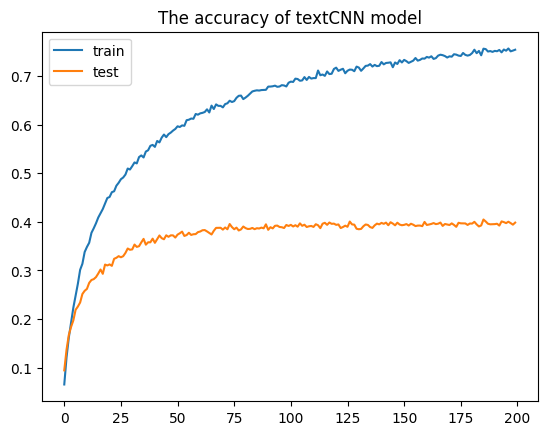

In [31]:
# 模型训练过程结果展示
plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)

# plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of textCNN model")
plt.legend(["train", 'test'])
plt.show()
